<h2 style='color: crimson; border-bottom: 1px seagreen dotted'>MUMBAI TRAVEL TIMES {Q4 2019}</h2>

Access Dataset here ---> [Uber Movement Mumbai](https://movement.uber.com/explore/mumbai/travel-times/query?si=254&ti=&ag=hexclusters&dt[tpb]=ALL_DAY&dt[wd;]=1,2,3,4,5,6,7&dt[dr][sd]=2020-03-01&dt[dr][ed]=2020-03-31&cd=&sa;=72.9132679,19.1334302&sdn=Indian%20Institute%20of%20Technology%20Bombay,%20Main%20Gate%20Rd,%20IIT%20Area,%20Powai,%20Mumbai,%20Maharashtra&lng.=72.8508724&lat.=19.122537&z.=10.01&lang=en-US)

![Mumbai Trave Times](mumbai_hexagons.png)
<p style='color:orange; padding-left: 20em; border: seagreen 1px dotted'> MUMBAI ORIGIN DESTINATION TRAVELTIME HEATMAP </p>

In [1]:
# install requirements
!pip install -q -r req.txt

You should consider upgrading via the '/home/sampad/miniconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
# Unzip if not already done
import os,shutil
if not 'mumbai-hexclusters-2019-4-All-HourlyAggregate.csv' in os.listdir():
    shutil.unpack_archive(filename="mumbai-hexclusters-2019-4-All-HourlyAggregate.zip",extract_dir='.')

In [24]:
# All imports


from prettyprinter import pprint 

import numpy as np
import pandas as pd
import json


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import seaborn as sns
sns.set_style('dark')

import tensorly as tl
from tensorly.decomposition import parafac


In [4]:
# read dataframe and metadata

df = pd.read_csv('mumbai-hexclusters-2019-4-All-HourlyAggregate.csv')
hexagons = json.load(open('mumbai_hexclusters.json'))['features']

In [5]:
# peek into dataframe
df.head()

,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
0,171,206,15,2949.31,1139.79,2772.51,1.40
1,255,439,10,5045.33,839.06,4978.27,1.18
2,110,18,0,2932.71,537.47,2886.25,1.19
3,38,7,5,2690.29,741.75,2591.41,1.31
4,277,219,10,4848.73,730.67,4796.48,1.16


```python

### definition ###
hod = hour of day
```


In [6]:
# peek metadata
pprint(hexagons[0])

{
    'type': 'Feature',
    'properties': {
        'MOVEMENT_ID': '1',
        'DISPLAY_NAME': '0, Beverly Park Rd, Chandan Shanti, Mira Road East'
    },
    'geometry': {
        'type': 'Polygon',
        'coordinates': [
            [
                [72.87164792379636, 19.28533060455805],
                [72.8710709563304, 19.28699016299829],
                [72.87222988623245, 19.288411970470293],
                [72.87165291120459, 19.290071498239048],
                [72.86991701541635, 19.29030919072361],
                [72.86934004196853, 19.29196866000375],
                [72.86760418931208, 19.292206301216417],
                [72.86702721744616, 19.293865712003942],
                [72.86529140792581, 19.294103301944087],
                [72.86413260267913, 19.292681516129214],
                [72.86470956539794, 19.291022133151962],
                [72.86355078499479, 19.289600351689437],
                [72.86412774015048, 19.287940938034637],
                [72.862

In [7]:
#test all unique
gdf = df.groupby(['sourceid','dstid', 'hod']).count()

if np.all(gdf==1): print('All good, no repeats')
else: print('Some src-dst-hod are repeated!!!')

All good, no repeats


In [90]:
origins = sorted(df.sourceid.unique())
destinations = sorted(df.dstid.unique())
hods = sorted(df.hod.unique())

origin_max = max(origins)
dest_max = max(destinations)
hod_max = max(hods)

list(map(min,[origins,destinations,hods]))

[1, 1, 0]

In [91]:
# Make numpy tensor
nptensor = np.zeros(     (   dest_max, origin_max, hod_max+1  )      ) 
        
def transfer(x):
    nptensor[x.dstid-1 ,x.sourceid-1, x.hod] = x.mean_travel_time
    return 0

df.pipe(transfer)

0

In [92]:
nptensor[300,3,10]

1718.02

In [93]:
# verify if nptensor has right data
df[df.sourceid==4] [ df.dstid==301 ] [ df.hod==10]

/home/sampad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/sampad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,sourceid,dstid,hod,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time
1261503,4,301,10,1718.02,619.9,1633.91,1.35


In [94]:
# create tensorly data
tensor = tl.tensor(nptensor)

In [157]:
# decompose
factors = parafac(tensor, rank=1)
weights, components = factors
factors

(weights, factors) : rank-1 CPTensor of shape (695, 695, 24) 

In [158]:
dst,src,hr = components
dst,src,hr = map(np.array, [dst,src,hr])

In [159]:
hr.shape

(24, 1)

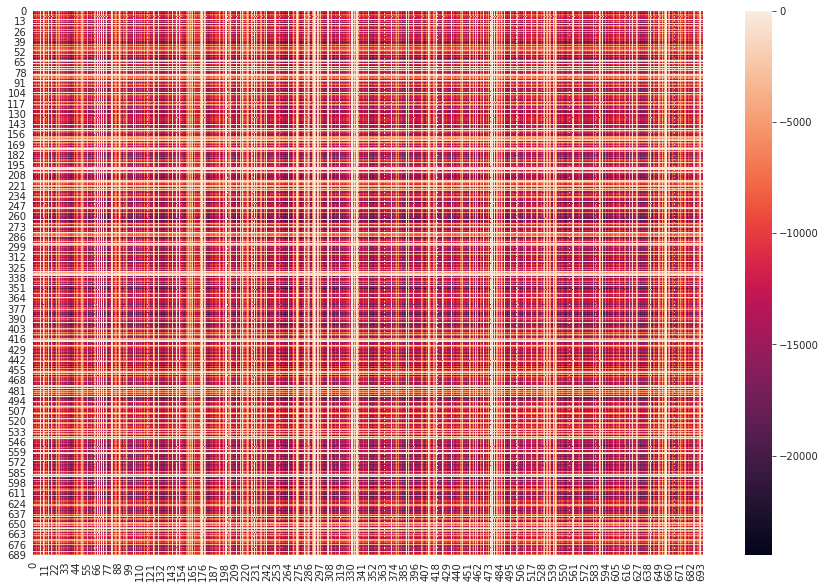

In [160]:
sns.heatmap(dst @ src.T)

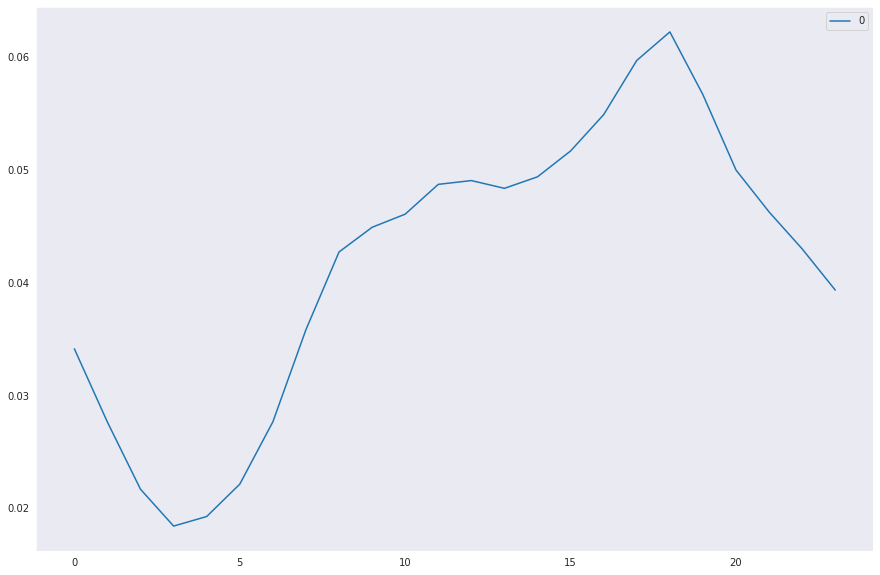

In [163]:
sns.lineplot(data=hr/hr.sum())

In [162]:
'''https://www.tomtom.com/en_gb/traffic-index/mumbai-traffic/'''
tomtom2019 = '''31%
16%
6%
0%
0%
0%
2%
9%
14%
19%
27%
39%
47%
46%
43%
47%
52%
57%
64%
67%
59%
48%
43%
33%
18%
3%
0%
0%
0%
0%
3%
26%
61%
80%
78%
70%
66%
59%
55%
58%
63%
76%
96%
104%
89%
66%
47%
30%
17%
6%
2%
0%
0%
0%
5%
27%
60%
80%
80%
74%
71%
65%
62%
65%
70%
82%
102%
109%
93%
70%
51%
34%
19%
6%
0%
0%
0%
0%
6%
29%
62%
83%
84%
79%
75%
69%
66%
68%
72%
83%
103%
109%
94%
71%
52%
35%
19%
6%
0%
0%
0%
0%
5%
27%
59%
78%
78%
73%
71%
66%
62%
65%
70%
82%
103%
111%
96%
72%
52%
35%
20%
6%
1%
0%
0%
1%
7%
29%
60%
80%
83%
80%
76%
67%
62%
68%
76%
90%
111%
119%
104%
81%
61%
44%
28%
11%
3%
0%
0%
2%
7%
18%
27%
38%
49%
63%
71%
71%
70%
74%
79%
83%
89%
91%
79%
63%
54%
44%'''

In [164]:
tomtomMatrix2019 = np.array(tomtom2019.replace('%','').split('\n'), dtype=np.int64).reshape(7,24)

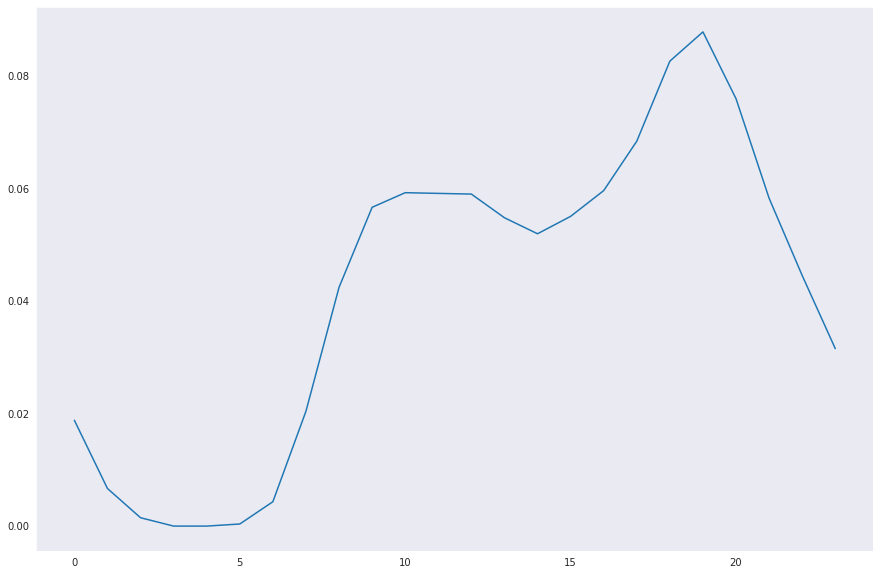

In [165]:
sns.lineplot(data=tomtomMatrix2019.sum(axis=0)/tomtomMatrix2019.sum())

In [213]:
tomtomnorm=tomtomMatrix2019.sum(axis=0).reshape(-1,1)/tomtomMatrix2019.sum()
hrnorm = data=hr/hr.sum()

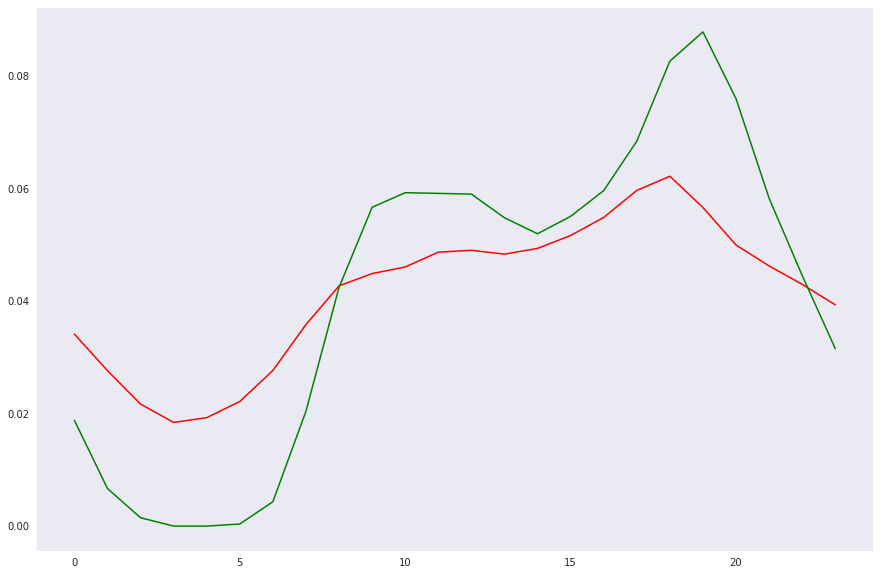

In [212]:
plt.plot(hrnorm,c='r')
plt.plot(tomtomnorm,c='g')